# ÇAPRAZ DİKKAT MEKANİZMALARIYLA HİBRİT FÜZYON

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Verileri TensorDataset'e dönüştür
train_dataset = TensorDataset(torch.tensor(text_train_windows, dtype=torch.float32),
                              torch.tensor(audio_train_windows, dtype=torch.float32),
                              torch.tensor(y_train_categorical, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(text_val_windows, dtype=torch.float32),
                            torch.tensor(audio_val_windows, dtype=torch.float32),
                            torch.tensor(y_val_categorical, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(text_test_windows, dtype=torch.float32),
                             torch.tensor(audio_test_windows, dtype=torch.float32),
                             torch.tensor(y_test_categorical, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class CrossModalAttention(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim):
        super(CrossModalAttention, self).__init__()
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8)
        self.self_attention_text = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8)
        self.self_attention_audio = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, text_features, audio_features):
        # Projeksiyonlar
        text_proj = self.text_proj(text_features)
        audio_proj = self.audio_proj(audio_features)

        # Çapraz dikkat
        text_attn, _ = self.cross_attention(text_proj, audio_proj, audio_proj)
        audio_attn, _ = self.cross_attention(audio_proj, text_proj, text_proj)

        # Kendiliğinden dikkat
        text_self_attn, _ = self.self_attention_text(text_proj, text_proj, text_proj)
        audio_self_attn, _ = self.self_attention_audio(audio_proj, audio_proj, audio_proj)

        # Birleştirme ve normalizasyon
        text_combined = self.layer_norm(text_proj + text_attn + text_self_attn)
        audio_combined = self.layer_norm(audio_proj + audio_attn + audio_self_attn)

        # Ort alma
        text_combined = torch.mean(text_combined, dim=1)
        audio_combined = torch.mean(audio_combined, dim=1)

        return text_combined, audio_combined

class FusionModel(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, num_classes):
        super(FusionModel, self).__init__()
        self.cross_modal_attention = CrossModalAttention(text_dim, audio_dim, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, text_features, audio_features):
        text_combined, audio_combined = self.cross_modal_attention(text_features, audio_features)
        combined_features = torch.cat((text_combined, audio_combined), dim=1)
        output = self.fc(combined_features)
        return output


In [ ]:
import torch.optim as optim

text_dim = text_train_windows.shape[2]
audio_dim = audio_train_windows.shape[2]
hidden_dim = 512
num_classes = y_train_categorical.shape[1]
num_epochs = 20
learning_rate = 0.001
batch_size = 32

# Model, kayıp fonksiyonu ve optimizasyon
model = FusionModel(text_dim, audio_dim, hidden_dim, num_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for text_features, audio_features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(text_features, audio_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')


    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for text_features, audio_features, labels in val_loader:
            outputs = model(text_features, audio_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions = torch.round(torch.sigmoid(outputs))
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(np.array(val_true_labels).argmax(axis=1), np.array(val_pred_labels).argmax(axis=1))
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Test seti üzerinde değerlendirme
model.eval()
test_loss = 0
test_true_labels = []
test_pred_labels = []
with torch.no_grad():
    for text_features, audio_features, labels in test_loader:
        outputs = model(text_features, audio_features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predictions = torch.round(torch.sigmoid(outputs))
        test_true_labels.extend(labels.cpu().numpy())
        test_pred_labels.extend(predictions.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = accuracy_score(np.array(test_true_labels).argmax(axis=1), np.array(test_pred_labels).argmax(axis=1))
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [1/20], Train Loss: 0.3277
Validation Loss: 0.2632, Validation Accuracy: 0.5068
Epoch [2/20], Train Loss: 0.2426
Validation Loss: 0.2687, Validation Accuracy: 0.5747
Epoch [3/20], Train Loss: 0.2319
Validation Loss: 0.2392, Validation Accuracy: 0.6063
Epoch [4/20], Train Loss: 0.2184
Validation Loss: 0.2304, Validation Accuracy: 0.5982
Epoch [5/20], Train Loss: 0.2238
Validation Loss: 0.2153, Validation Accuracy: 0.6145
Epoch [6/20], Train Loss: 0.2183
Validation Loss: 0.2099, Validation Accuracy: 0.6018
Epoch [7/20], Train Loss: 0.1997
Validation Loss: 0.2370, Validation Accuracy: 0.5846
Epoch [8/20], Train Loss: 0.1977
Validation Loss: 0.2032, Validation Accuracy: 0.6733
Epoch [9/20], Train Loss: 0.1928
Validation Loss: 0.2041, Validation Accuracy: 0.6452
Epoch [10/20], Train Loss: 0.1888
Validation Loss: 0.2012, Validation Accuracy: 0.6525
Epoch [11/20], Train Loss: 0.1942
Validation Loss: 0.1919, Validation Accuracy: 0.6398
Epoch [12/20], Train Loss: 0.1829
Validation Loss: 0

In [ ]:
import torch
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FusionModel(text_dim, audio_dim, hidden_dim, num_classes).to(device)

summary(model, [(window_size, text_dim), (window_size, audio_dim)], device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 5, 512]         154,112
            Linear-2               [-1, 5, 512]         825,344
MultiheadAttention-3  [[-1, 5, 512], [-1, 2, 2]]               0
MultiheadAttention-4  [[-1, 5, 512], [-1, 2, 2]]               0
MultiheadAttention-5  [[-1, 5, 512], [-1, 2, 2]]               0
MultiheadAttention-6  [[-1, 5, 512], [-1, 2, 2]]               0
         LayerNorm-7               [-1, 5, 512]           1,024
         LayerNorm-8               [-1, 5, 512]           1,024
CrossModalAttention-9     [[-1, 512], [-1, 512]]               0
           Linear-10                  [-1, 512]         524,800
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 7]           3,591
Total params: 1,509,895
Trainable params: 1,509,895
Non-trainable params: 0
----------------------

Test Loss: 0.1666, Test Accuracy: 0.7590
Test Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.67      0.52       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.74      0.78      0.76       402
           4       0.90      0.93      0.92      1252
           5       0.48      0.07      0.12       208
           6       0.81      0.90      0.85       281

    accuracy                           0.76      2606
   macro avg       0.48      0.48      0.45      2606
weighted avg       0.73      0.76      0.73      2606



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


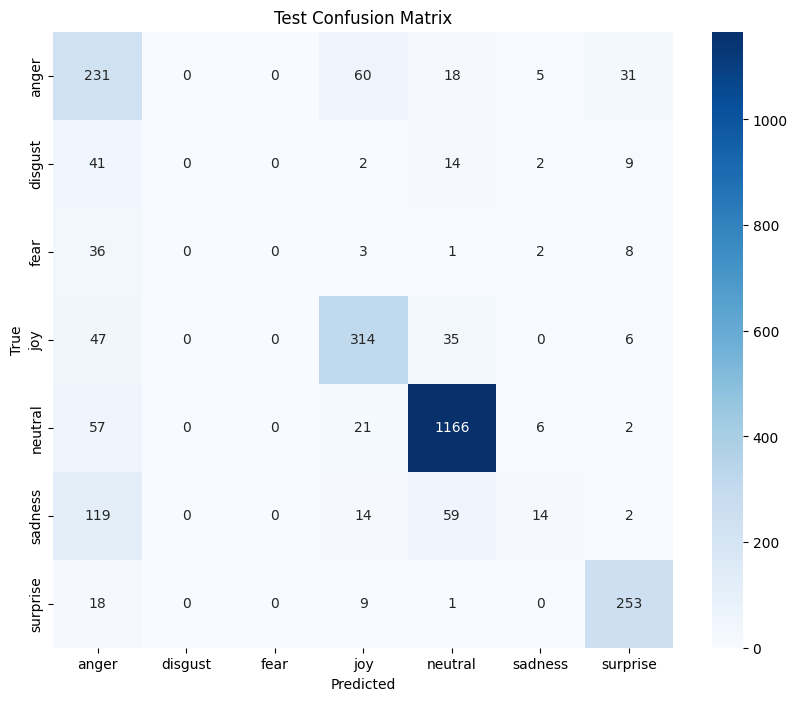

In [ ]:
avg_test_loss = test_loss / len(test_loader)
test_accuracy = accuracy_score(np.array(test_true_labels).argmax(axis=1), np.array(test_pred_labels).argmax(axis=1))
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Sınıflandırma Raporu ve Karışıklık Matrisi
print("Test Classification Report:")
print(classification_report(np.array(test_true_labels).argmax(axis=1), np.array(test_pred_labels).argmax(axis=1)))

conf_mat = confusion_matrix(np.array(test_true_labels).argmax(axis=1), np.array(test_pred_labels).argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

val_true_labels = np.array(val_true_labels).argmax(axis=1)
val_pred_labels = np.array(val_pred_labels).argmax(axis=1)
val_f1_scores = f1_score(val_true_labels, val_pred_labels, average=None)
val_class_report = classification_report(val_true_labels, val_pred_labels, target_names=label_mapping.keys())

test_true_labels = np.array(test_true_labels).argmax(axis=1)
test_pred_labels = np.array(test_pred_labels).argmax(axis=1)
test_f1_scores = f1_score(test_true_labels, test_pred_labels, average=None)
test_class_report = classification_report(test_true_labels, test_pred_labels, target_names=label_mapping.keys())

val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')


classes = list(label_mapping.keys())


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

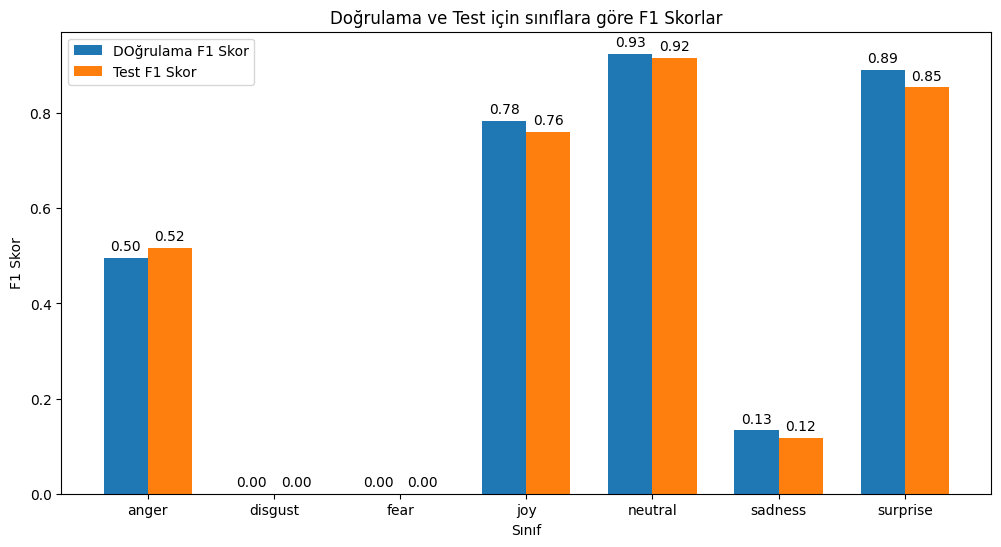

In [ ]:
x = np.arange(len(classes))  # Sınıf sayısı kadar bir dizi oluştur
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, val_f1_scores, width, label='DOğrulama F1 Skor')
bars2 = ax.bar(x + width/2, test_f1_scores, width, label='Test F1 Skor')

# Etiketler
ax.set_xlabel('Sınıf')
ax.set_ylabel('F1 Skor')
ax.set_title('Doğrulama ve Test için sınıflara göre F1 Skorlar')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Barların üzerine F1 skorlarını yazma
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.show()


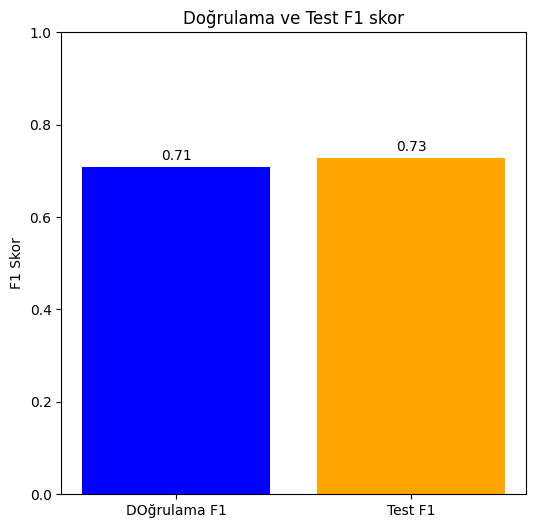

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
scores = [val_f1, test_f1]
labels = ['DOğrulama F1', 'Test F1']

bars = ax.bar(labels, scores, color=['blue', 'orange'])

# Barların üzerine F1 skorlarını yazma
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylim(0, 1)  # F1 skorları 0 ile 1 arasında olduğundan eksen aralığını ayarlayın
ax.set_ylabel('F1 Skor')
ax.set_title('Doğrulama ve Test F1 skor')

plt.show()

#HİBRİT

In [ ]:
#metin
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, LSTM

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, LSTM

text_input = Input(shape=(window_size, text_train_windows.shape[-1]))
x = Bidirectional(LSTM(256, return_sequences=True))(text_input)
x = Bidirectional(LSTM(128))(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
text_output = Dense(len(label_mapping), activation='softmax')(x)

text_model = Model(inputs=text_input, outputs=text_output)
text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_text = text_model.fit(text_train_windows, y_train_categorical, validation_data=(text_val_windows, y_val_categorical), epochs=50, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)])


val_pred_text_probs = text_model.predict(text_val_windows)
test_pred_text_probs = text_model.predict(text_test_windows)

val_pred_text_labels = val_pred_text_probs.argmax(axis=-1)
test_pred_text_labels = test_pred_text_probs.argmax(axis=-1)

val_f1_text_score = f1_score(y_val_windows, val_pred_text_labels, average='weighted')
test_f1_text_score = f1_score(y_test_windows, test_pred_text_labels, average='weighted')

print("Validation F1 Score for Text Model:", val_f1_text_score)
print("Test F1 Score for Text Model:", test_f1_text_score)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5297 - loss: 1.4089 - val_accuracy: 0.6724 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7292 - loss: 0.8190 - val_accuracy: 0.6995 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7638 - loss: 0.7253 - val_accuracy: 0.7412 - val_loss: 0.8195 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7883 - loss: 0.6085 - val_accuracy: 0.6959 - val_loss: 0.9811 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8075 - loss: 0.5544 - val_accuracy: 0.7357 - val_loss: 0.8590 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8294 - loss: 0.5009 - val_accuracy: 0.7421 - val_loss: 0.7692 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8331 - loss: 0.

In [ ]:
audio_input = Input(shape=(window_size, audio_train_windows.shape[-1]))


def create_audio_model(modality_input):
    x = Bidirectional(LSTM(1024, return_sequences=True))(modality_input)
    x = Bidirectional(LSTM(512))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    modality_output = Dense(len(label_mapping), activation='softmax')(x)
    return modality_output

audio_output = create_audio_model(audio_input)


audio_model = Model(inputs=audio_input, outputs=audio_output)
audio_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
audio_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5, 1611)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 5, 2048)             │      21,594,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1024)                │      10,489,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,612,359 (124.41 MB)

 Trainable params: 32,612,359 (124.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
audio_input = Input(shape=(window_size, audio_train_windows.shape[-1]))


def create_audio_model(modality_input):
    x = Bidirectional(LSTM(1024, return_sequences=True))(modality_input)
    x = Bidirectional(LSTM(512))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    modality_output = Dense(len(label_mapping), activation='softmax')(x)
    return modality_output

audio_output = create_audio_model(audio_input)


audio_model = Model(inputs=audio_input, outputs=audio_output)
audio_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_audio = audio_model.fit(audio_train_windows, y_train_categorical, validation_data=(audio_val_windows, y_val_categorical), epochs=50, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)])

val_pred_audio_probs = audio_model.predict(audio_val_windows)
test_pred_audio_probs = audio_model.predict(audio_test_windows)

val_pred_labels = val_pred_audio_probs.argmax(axis=-1)
test_pred_labels = test_pred_audio_probs.argmax(axis=-1)

val_f1_audio_score = f1_score(y_val_windows, val_pred_labels, average='weighted')
test_f1_audio_score = f1_score(y_test_windows, test_pred_labels, average='weighted')

print("Validation F1 Score for Audio Model:", val_f1_audio_score)
print("Test F1 Score for Audio Model:", test_f1_audio_score)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4270 - loss: 1.7323 - val_accuracy: 0.4217 - val_loss: 1.6415 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4687 - loss: 1.5665 - val_accuracy: 0.4217 - val_loss: 1.6701 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4700 - loss: 1.5658 - val_accuracy: 0.4217 - val_loss: 1.6310 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4658 - loss: 1.5679 - val_accuracy: 0.4217 - val_loss: 1.6443 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4716 - loss: 1.5443 - val_accuracy: 0.4217 - val_loss: 1.6283 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4739 - loss: 1.5309 - val_accuracy: 0.3701 - val_loss: 1.6667 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4782 - loss: 1.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 5, 300)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 5, 1611)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 5, 512)         │      1,140,736 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 5, 2048)        │     21,594,112 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        656,384 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 1024)           │     10,489,856 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        524,800 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 7)              │          1,799 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 7)              │          3,591 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 14)             │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │          7,680 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ batch_normalization[0… │
├──────────────────────

 Total params: 34,653,461 (132.19 MB)

 Trainable params: 34,651,669 (132.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6835 - loss: 5.8368 - val_accuracy: 0.4398 - val_loss: 4.1908
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8155 - loss: 2.9064 - val_accuracy: 0.4968 - val_loss: 2.8255
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8220 - loss: 1.6842 - val_accuracy: 0.5738 - val_loss: 2.0403
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8343 - loss: 1.1072 - val_accuracy: 0.7357 - val_loss: 1.2468
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8635 - loss: 0.7870 - val_accuracy: 0.7231 - val_loss: 1.1555
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8531 - loss: 0.7012 - val_accuracy: 0.6633 - val_loss: 1.6684
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8770 - loss: 0.5766 - val_accuracy: 0.7303 - val_loss: 1.1756
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8811 - loss: 0.5415 -

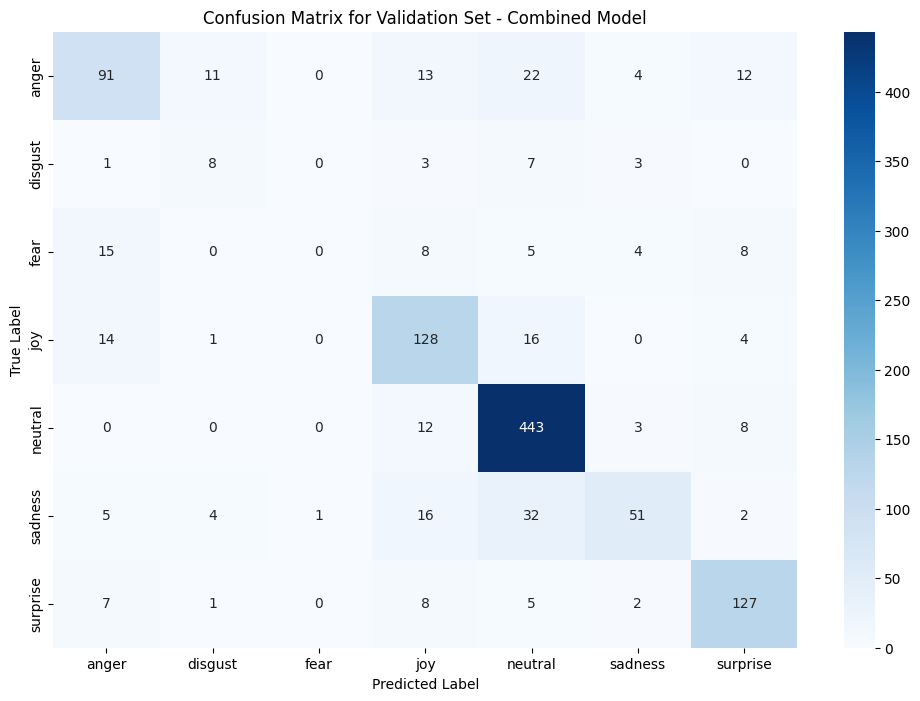

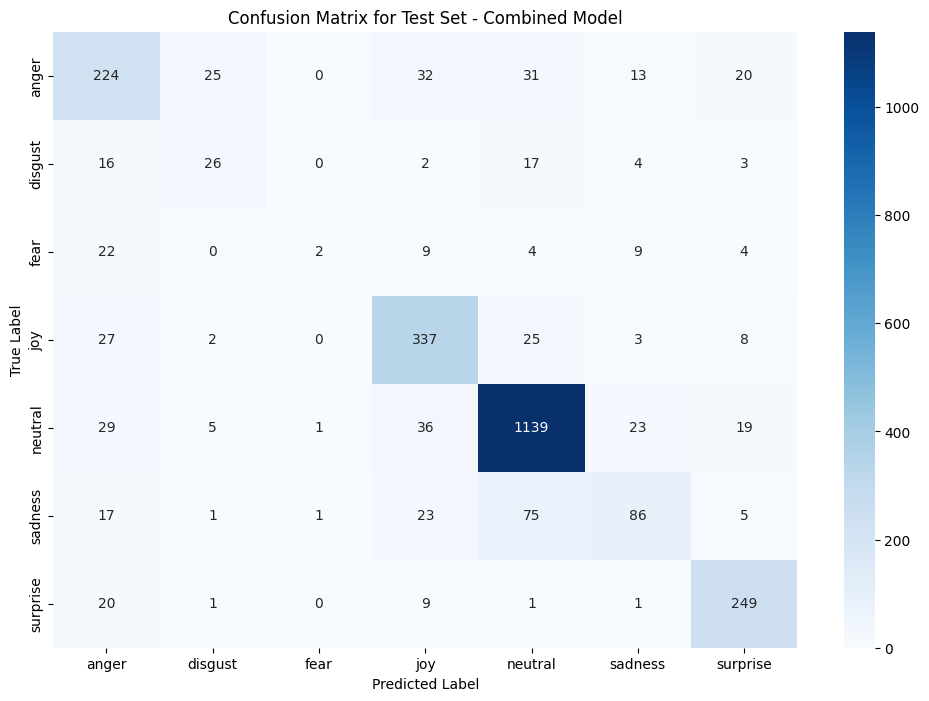

In [ ]:
from keras.layers import concatenate
from keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from keras.models import Model
from keras.optimizers import Adam


combined = concatenate([text_model.output, audio_model.output])



combined_layer = Dense(512, activation='relu', kernel_regularizer='l2')(combined)
combined_layer = BatchNormalization()(combined_layer)
combined_layer = Dropout(0.5)(combined_layer)
combined_layer = Dense(256, activation='relu', kernel_regularizer='l2')(combined_layer)
combined_layer = BatchNormalization()(combined_layer)
combined_layer = Dropout(0.5)(combined_layer)
combined_layer = Dense(128, activation='relu', kernel_regularizer='l2')(combined_layer)
combined_layer = BatchNormalization()(combined_layer)
combined_layer = Dropout(0.5)(combined_layer)
output_layer = Dense(len(label_mapping), activation='softmax')(combined_layer)

final_model = Model(inputs=[text_model.input, audio_model.input], outputs=output_layer)
final_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

early_stopping_combined = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_combined = final_model.fit([text_train_windows, audio_train_windows], y_train_categorical,
                                   epochs=100, batch_size=64,
                                   validation_data=([text_val_windows, audio_val_windows], y_val_categorical),
                                   callbacks=[early_stopping_combined])

val_pred_combined_probs = final_model.predict([text_val_windows, audio_val_windows])
test_pred_combined_probs = final_model.predict([text_test_windows, audio_test_windows])

val_pred_combined_labels = val_pred_combined_probs.argmax(axis=-1)
test_pred_combined_labels = test_pred_combined_probs.argmax(axis=-1)


val_f1_combined_score = f1_score(y_val_windows, val_pred_combined_labels, average='weighted')
test_f1_combined_score = f1_score(y_test_windows, test_pred_combined_labels, average='weighted')

print("Validation F1 Score for Combined Model:", val_f1_combined_score)
print("Test F1 Score for Combined Model:", test_f1_combined_score)


conf_matrix_val_combined = confusion_matrix(y_val_windows, val_pred_combined_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_val_combined, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Validation Set - Combined Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

conf_matrix_test_combined = confusion_matrix(y_test_windows, test_pred_combined_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_test_combined, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Test Set - Combined Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print("Validation Classification Report:")
print(classification_report(y_val_windows, val_pred_combined_labels, target_names=le.classes_))
print("Test Classification Report:")
print(classification_report(y_test_windows, test_pred_combined_labels, target_names=le.classes_))


Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.59      0.64       153
     disgust       0.32      0.36      0.34        22
        fear       0.00      0.00      0.00        40
         joy       0.68      0.79      0.73       163
     neutral       0.84      0.95      0.89       466
     sadness       0.76      0.46      0.57       111
    surprise       0.79      0.85      0.82       150

    accuracy                           0.77      1105
   macro avg       0.58      0.57      0.57      1105
weighted avg       0.74      0.77      0.75      1105

Test Classification Report:
              precision    recall  f1-score   support

       anger       0.63      0.65      0.64       345
     disgust       0.43      0.38      0.41        68
        fear       0.50      0.04      0.07        50
         joy       0.75      0.84      0.79       402
     neutral       0.88      0.91      0.90      1252
     sadness    